In [3]:
import pandas as pd

# 파일 불러오기
승인매출정보 = pd.read_parquet("merged_승인매출정보.parquet")
회원정보 = pd.read_parquet("merged_회원정보.parquet")

# '카드론' 포함 컬럼명 추출
card_loan_cols  = [col for col in 승인매출정보.columns if '카드론' in col]

# ID + 카드론 컬럼만 추출
카드론 = 승인매출정보[['ID'] + card_loan_cols]

# ▶ 카드론 컬럼을 ID 기준으로 집계 (sum 또는 count)
card_loan_total = 카드론.groupby('ID')[card_loan_cols].sum().reset_index()

# 회원정보에서 ID와 Segment 추출
회원_선택 = 회원정보[['ID', 'Segment']]

# 병합 (고객 단위로)
병합결과 = pd.merge(card_loan_total, 회원_선택, on='ID', how='left')

# 확인
print("병합 후 shape:", 병합결과.shape)
print(병합결과.head())


병합 후 shape: (2400000, 28)
             ID  최종이용일자_카드론  이용건수_카드론_B0M  이용금액_카드론_B0M  이용후경과월_카드론  \
0  TRAIN_000000       60606             0             0          72   
1  TRAIN_000000       60606             0             0          72   
2  TRAIN_000000       60606             0             0          72   
3  TRAIN_000000       60606             0             0          72   
4  TRAIN_000000       60606             0             0          72   

   이용건수_카드론_R12M  이용금액_카드론_R12M  최대이용금액_카드론_R12M  이용개월수_카드론_R12M  \
0              0              0                0               0   
1              0              0                0               0   
2              0              0                0               0   
3              0              0                0               0   
4              0              0                0               0   

   이용건수_카드론_R6M  ...  카드론이용월수_누적  카드론이용금액_누적  최종카드론_금융상환방식코드  최종카드론_신청경로코드  \
0             0  ...           0           0             0.0

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rc('font', family='pretendard')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

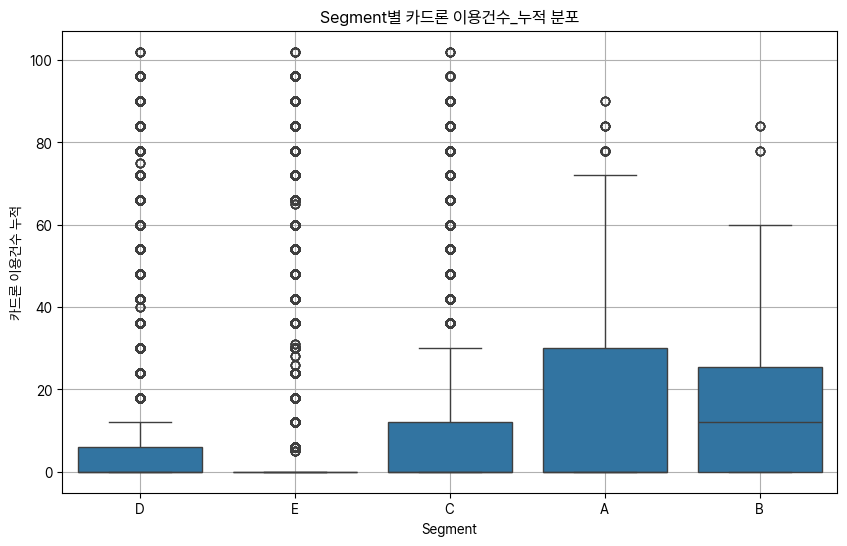

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='카드론이용건수_누적', data=병합결과)
plt.title('Segment별 카드론 이용건수_누적 분포')
plt.xlabel('Segment')
plt.ylabel('카드론 이용건수 누적')
plt.grid(True)
plt.show()

In [11]:
병합결과.groupby('Segment')['카드론이용건수_누적'].agg(['count', 'mean', 'median', 'std', 'max'])

,count,mean,median,std,max
Segment,,,,,
A,972,16.481481,0.0,25.349111,90
B,144,20.250000,12.0,25.592695,84
C,127590,9.856760,0.0,18.121536,102
D,349242,6.586819,0.0,14.506588,102
E,1922052,3.358504,0.0,10.309300,102


In [12]:
from scipy.stats import f_oneway

# 각 세그먼트별 리스트 생성
group_a = 병합결과[병합결과['Segment'] == 'A']['카드론이용건수_누적']
group_b = 병합결과[병합결과['Segment'] == 'B']['카드론이용건수_누적']
group_c = 병합결과[병합결과['Segment'] == 'C']['카드론이용건수_누적']
group_d = 병합결과[병합결과['Segment'] == 'D']['카드론이용건수_누적']
group_e = 병합결과[병합결과['Segment'] == 'E']['카드론이용건수_누적']

# ANOVA
f_stat, p_val = f_oneway(group_a, group_b, group_c, group_d, group_e)
print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 14262.83044412394
p-value: 0.0


In [13]:
병합결과['카드론이용여부'] = 병합결과['카드론이용건수_누적'] > 0

pd.crosstab(병합결과['Segment'], 병합결과['카드론이용여부'], normalize='index') * 100

카드론이용여부,False,True
Segment,,
A,60.493827,39.506173
B,45.833333,54.166667
C,67.820362,32.179638
D,74.733280,25.266720
E,85.475211,14.524789


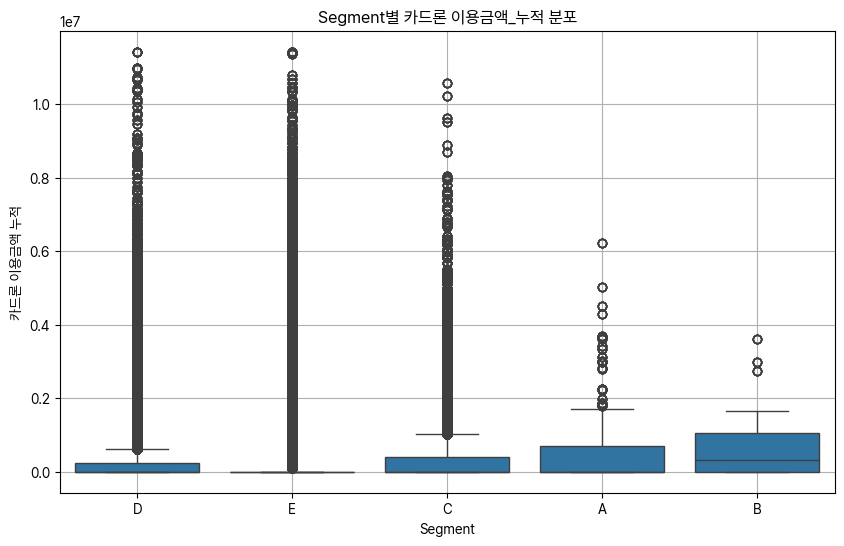

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='카드론이용금액_누적', data=병합결과)
plt.title('Segment별 카드론 이용금액_누적 분포')
plt.xlabel('Segment')
plt.ylabel('카드론 이용금액 누적')
plt.grid(True)
plt.show()

In [16]:
# 세그먼트별 평균, 중앙값, 표준편차 등 비교
avg_summary = 병합결과.groupby('Segment')['카드론이용금액_누적'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

# 보기 좋게 소수점 둘째 자리까지 반올림
avg_summary = avg_summary.round(2)

print("세그먼트별 카드론 이용 누적금액 요약 통계:")
display(avg_summary)


세그먼트별 카드론 이용 누적금액 요약 통계:


,count,mean,median,std,min,max
Segment,,,,,,
A,972,616140.96,0.0,1147889.48,0,6207870
B,144,741663.75,305940.0,1044417.41,0,3597120
C,127590,327062.52,0.0,740096.59,0,10569300
D,349242,233252.16,0.0,645731.78,0,11420334
E,1922052,127388.48,0.0,459644.14,0,11420334


In [17]:
# 카드론 이용여부 컬럼 생성
병합결과['카드론금액_이용여부'] = 병합결과['카드론이용금액_누적'] > 0

# 세그먼트별 카드론 이용 비율 계산 (%)
cardloan_rate = pd.crosstab(병합결과['Segment'], 병합결과['카드론금액_이용여부'], normalize='index') * 100
cardloan_rate.columns = ['미이용자 (%)', '이용자 (%)']
cardloan_rate = cardloan_rate[['이용자 (%)', '미이용자 (%)']]  # 보기 좋게 순서 정리

print("세그먼트별 카드론 이용자 비율 (%):")
display(cardloan_rate.round(2))

세그먼트별 카드론 이용자 비율 (%):


,이용자 (%),미이용자 (%)
Segment,,
A,40.74,59.26
B,54.17,45.83
C,33.22,66.78
D,26.80,73.20
E,15.86,84.14


In [18]:
final_cardloan_cols = [col for col in 병합결과.columns if '최종카드론_' in col]
print("최종카드론 관련 컬럼:")
print(final_cardloan_cols)

최종카드론 관련 컬럼:
['최종카드론_금융상환방식코드', '최종카드론_신청경로코드', '최종카드론_대출이율', '최종카드론_대출일자', '최종카드론_대출월수', '최종카드론_거치개월수', '최종카드론_대출금액']


In [19]:
# 각 컬럼별 예시 값 5개 확인
for col in final_cardloan_cols:
    print(f"\n[{col}]")
    print(병합결과[col].value_counts(dropna=False).head())


[최종카드론_금융상환방식코드]
최종카드론_금융상환방식코드
0.0     1957002
12.0     312114
30.0     106896
18.0       4134
15.0       3072
Name: count, dtype: int64

[최종카드론_신청경로코드]
최종카드론_신청경로코드
0         1956912
888888     216294
777777      98556
111111      42294
DDDDDD       7302
Name: count, dtype: int64

[최종카드론_대출이율]
최종카드론_대출이율
0.000000      1956486
101.299810         12
84.936949          12
101.565421         12
93.310552          12
Name: count, dtype: int64

[최종카드론_대출일자]
최종카드론_대출일자
0.0            1988328
121082412.0       1122
121082442.0       1110
121082460.0       1110
121082472.0       1110
Name: count, dtype: int64

[최종카드론_대출월수]
최종카드론_대출월수
0      1956906
144     156078
72      150300
216      75066
96       10710
Name: count, dtype: int64

[최종카드론_거치개월수]
최종카드론_거치개월수
0     2291982
36      58968
18      24414
30       3984
21       3030
Name: count, dtype: int64

[최종카드론_대출금액]
최종카드론_대출금액
0         1956906
291294         30
203111         24
214731         24
187451         24
Name: count, dtype: int64

In [20]:
# 이자율 값이 0 또는 결측(NaN)이 아닌 고객만 추출
이자율데이터 = 병합결과[병합결과['최종카드론_대출이율'] > 0].copy()
print("유효한 이자율 데이터 수:", 이자율데이터.shape)

유효한 이자율 데이터 수: (443514, 30)


In [21]:
이자율통계 = 이자율데이터.groupby('Segment')['최종카드론_대출이율'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

print("세그먼트별 최종카드론 대출이율 요약:")
display(이자율통계)

세그먼트별 최종카드론 대출이율 요약:


,count,mean,median,std,min,max
Segment,,,,,,
A,396,98.54,98.92,7.37,79.12,111.48
B,78,95.70,99.53,10.49,73.07,109.67
C,42432,95.65,96.44,7.76,32.63,118.17
D,93822,93.46,94.80,8.30,14.71,117.47
E,306786,90.57,92.63,9.30,12.73,118.10


In [22]:
# 실제 대출한 고객만 (대출금액 > 0)
대출금액_유효 = 병합결과[병합결과['최종카드론_대출금액'] > 0].copy()
print("유효 대출 고객 수:", len(대출금액_유효))

유효 대출 고객 수: 443094


In [23]:
금액통계 = 대출금액_유효.groupby('Segment')['최종카드론_대출금액'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

print("세그먼트별 최종카드론 대출금액 요약:")
display(금액통계)

세그먼트별 최종카드론 대출금액 요약:


,count,mean,median,std,min,max
Segment,,,,,,
A,396,293935.17,245031.5,135156.83,115482,699070
B,78,368437.69,243366.0,213934.70,196170,842527
C,42414,297604.94,263527.0,146861.55,667,1000152
D,93702,310271.50,267549.0,166295.33,188,1007882
E,306504,340605.18,283621.5,182901.21,34,1028378


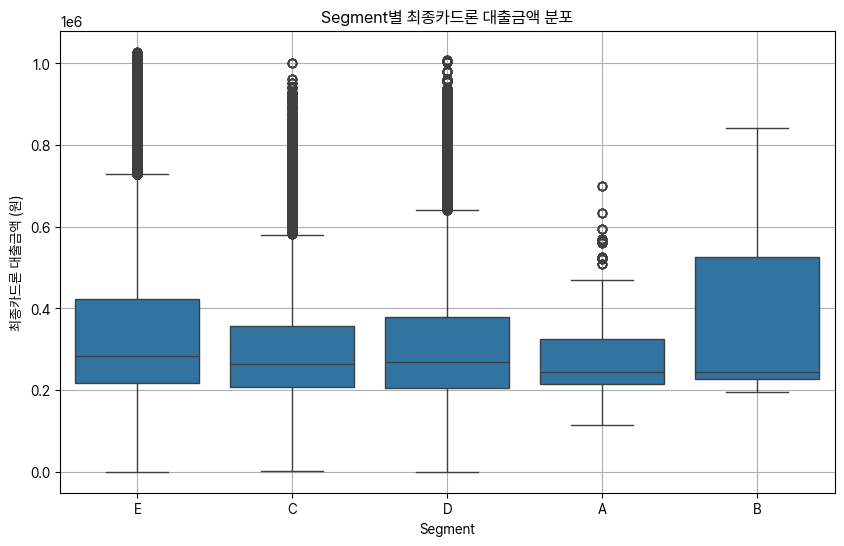

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='최종카드론_대출금액', data=대출금액_유효)
plt.title('Segment별 최종카드론 대출금액 분포')
plt.xlabel('Segment')
plt.ylabel('최종카드론 대출금액 (원)')
plt.grid(True)
plt.show()

In [25]:
대출_조건부 = 병합결과[(병합결과['최종카드론_대출금액'] > 0) & (병합결과['최종카드론_대출이율'] > 0)]

세그_요약 = 대출_조건부.groupby('Segment')[['최종카드론_대출금액', '최종카드론_대출이율']].agg(['count', 'mean', 'median', 'std']).round(2)

print("세그먼트별 대출금액 + 대출이율 요약:")
display(세그_요약)

세그먼트별 대출금액 + 대출이율 요약:


최종카드론_대출금액                                 최종카드론_대출이율                \
             count       mean    median        std      count   mean median   
Segment                                                                       
A              396  293935.17  245031.5  135156.83        396  98.54  98.92   
B               78  368437.69  243366.0  213934.70         78  95.70  99.53   
C            42414  297604.94  263527.0  146861.55      42414  95.64  96.44   
D            93702  310271.50  267549.0  166295.33      93702  93.44  94.78   
E           306498  340611.14  283625.0  182898.04     306498  90.55  92.62   

                
           std  
Segment         
A         7.37  
B        10.49  
C         7.75  
D         8.28  
E         9.29

C:\Users\somee\AppData\Local\Temp\ipykernel_21916\2036063156.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_대출.groupby(['Segment', '대출금액_구간'])['최종카드론_대출이율'].mean().reset_index()


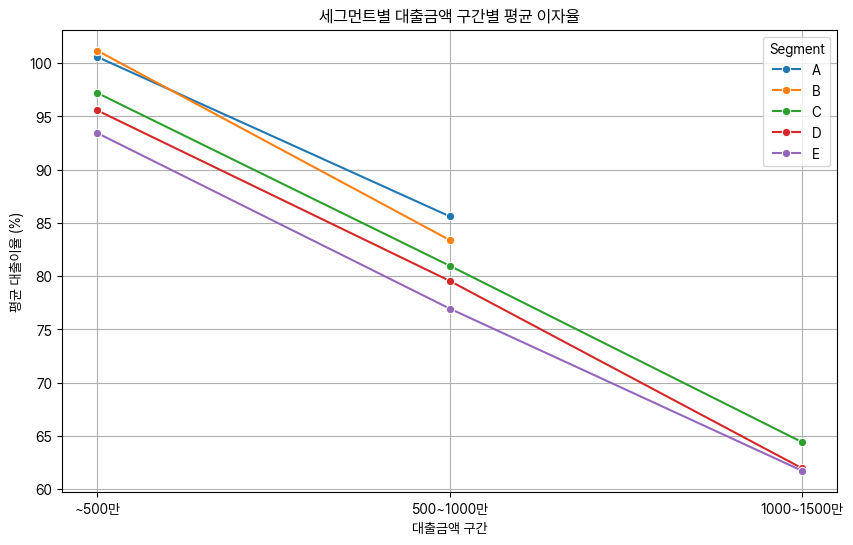

In [29]:
# 대출금액 구간화 (ex: 0~500만, 500만~1000만, 1000만~1500만 ...)
bins = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000]
labels = ['~500만', '500~1000만', '1000~1500만', '1500~2000만', '2000~2500만', '2500만 이상']
df_대출['대출금액_구간'] = pd.cut(df_대출['최종카드론_대출금액'], bins=bins, labels=labels, right=False)

# 세그먼트별 + 대출금액 구간별 평균 이자율
grouped = df_대출.groupby(['Segment', '대출금액_구간'])['최종카드론_대출이율'].mean().reset_index()

# 선그래프
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='대출금액_구간', y='최종카드론_대출이율', hue='Segment', marker='o')
plt.title('세그먼트별 대출금액 구간별 평균 이자율')
plt.xlabel('대출금액 구간')
plt.ylabel('평균 대출이율 (%)')
plt.grid(True)
plt.show()
